# Inspired by the work of [Hirotaka Kawashima](https://www.kaggle.com/code/hirotaka0122/triplet-loss-with-pytorch/notebook)

## Original Code

In [1]:
import time
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

In [2]:
PATH = "./digit-recognizer/"

torch.manual_seed(2020)
np.random.seed(2020)
random.seed(2020)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    torch.cuda.get_device_name()

In [3]:
embedding_dims = 2
batch_size = 32
epochs = 50

In [4]:
train_df = pd.read_csv(PATH+"train.csv")
test_df = pd.read_csv(PATH+"test.csv")

train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
class MNIST(Dataset):
    def __init__(self, df, train=True, transform=None):
        self.is_train = train
        self.transform = transform
        self.to_pil = transforms.ToPILImage()

        if self.is_train:
            self.images = df.iloc[:, 1:].values.astype(np.uint8)
            self.labels = df.iloc[:, 0].values
            self.index = df.index.values
        else:
            self.images = df.values.astype(np.uint8)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, item):
        anchor_img = self.images[item].reshape(28, 28, 1)

        if self.is_train:
            anchor_label = self.labels[item]

            positive_list = self.index[self.index!=item][self.labels[self.index!=item]==anchor_label]

            positive_item = random.choice(positive_list)
            positive_img = self.images[positive_item].reshape(28, 28, 1)

            negative_list = self.index[self.index!=item][self.labels[self.index!=item]!=anchor_label]
            negative_item = random.choice(negative_list)
            negative_img = self.images[negative_item].reshape(28, 28, 1)

            if self.transform:
                anchor_img = self.transform(self.to_pil(anchor_img))
                positive_img = self.transform(self.to_pil(positive_img))
                negative_img = self.transform(self.to_pil(negative_img))

            return anchor_img, positive_img, negative_img, anchor_label

        else:
            if self.transform:
                anchor_img = self.transform(self.to_pil(anchor_img))
            return anchor_img

In [6]:
train_ds = MNIST(train_df,
                 train=True,
                 transform=transforms.Compose([
                     transforms.ToTensor()
                 ]))
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)

In [7]:
test_ds = MNIST(test_df, train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4)

In [8]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)

    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

In [9]:
class Network(nn.Module):
    def __init__(self, emb_dim=128):
        super(Network, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.PReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3),
            nn.Conv2d(32, 64, 5),
            nn.PReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3)
        )

        self.fc = nn.Sequential(
            nn.Linear(64*4*4, 512),
            nn.PReLU(),
            nn.Linear(512, emb_dim)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 64*4*4)
        x = self.fc(x)
        # x = nn.functional.normalize(x)
        return x

In [10]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight)

In [11]:
model = Network(embedding_dims)
model.apply(init_weights)
model = torch.jit.script(model).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.jit.script(TripletLoss())

In [12]:
model.train()
for epoch in tqdm(range(epochs), desc="Epochs"):
    running_loss = []
    for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)

        optimizer.zero_grad()
        anchor_out = model(anchor_img)
        positive_out = model(positive_img)
        negative_out = model(negative_img)

        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()

        running_loss.append(loss.cpu().detach().numpy())
    print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, epochs, np.mean(running_loss)))

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 1/50 - Loss: 0.2273


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 2/50 - Loss: 0.1042


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 3/50 - Loss: 0.0762


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 4/50 - Loss: 0.0651


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 5/50 - Loss: 0.0595


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 6/50 - Loss: 0.0527


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 7/50 - Loss: 0.0469


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 8/50 - Loss: 0.0457


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 9/50 - Loss: 0.0429


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 10/50 - Loss: 0.0417


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 11/50 - Loss: 0.0402


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 12/50 - Loss: 0.0363


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 13/50 - Loss: 0.0329


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 14/50 - Loss: 0.0310


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 15/50 - Loss: 0.0349


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 16/50 - Loss: 0.0317


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 17/50 - Loss: 0.0313


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 18/50 - Loss: 0.0298


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 19/50 - Loss: 0.0299


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 20/50 - Loss: 0.0293


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 21/50 - Loss: 0.0283


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 22/50 - Loss: 0.0285


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 23/50 - Loss: 0.0250


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 24/50 - Loss: 0.0275


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 25/50 - Loss: 0.0290


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 26/50 - Loss: 0.0242


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 27/50 - Loss: 0.0264


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 28/50 - Loss: 0.0248


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 29/50 - Loss: 0.0206


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 30/50 - Loss: 0.0253


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 31/50 - Loss: 0.0219


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 32/50 - Loss: 0.0224


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 33/50 - Loss: 0.0229


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 34/50 - Loss: 0.0241


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 35/50 - Loss: 0.0208


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 36/50 - Loss: 0.0225


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 37/50 - Loss: 0.0196


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 38/50 - Loss: 0.0208


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 39/50 - Loss: 0.0220


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 40/50 - Loss: 0.0220


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 41/50 - Loss: 0.0190


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 42/50 - Loss: 0.0199


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 43/50 - Loss: 0.0203


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 44/50 - Loss: 0.0206


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 45/50 - Loss: 0.0210


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 46/50 - Loss: 0.0183


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 47/50 - Loss: 0.0188


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 48/50 - Loss: 0.0196


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 49/50 - Loss: 0.0198


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 50/50 - Loss: 0.0192


In [13]:
torch.save({"model_state_dict": model.state_dict(),
            "optimzier_state_dict": optimizer.state_dict()
           }, "trained_model.pth")

In [26]:
train_results = []
labels = []

model.eval()
with torch.no_grad():
    for img, _, _, label in tqdm(train_loader):
        train_results.append(model(img.to(device)).cpu().numpy())
        labels.append(label)

train_results = np.concatenate(train_results)
labels = np.concatenate(labels)
train_results.shape

  0%|          | 0/1313 [00:00<?, ?it/s]

(42000, 2)

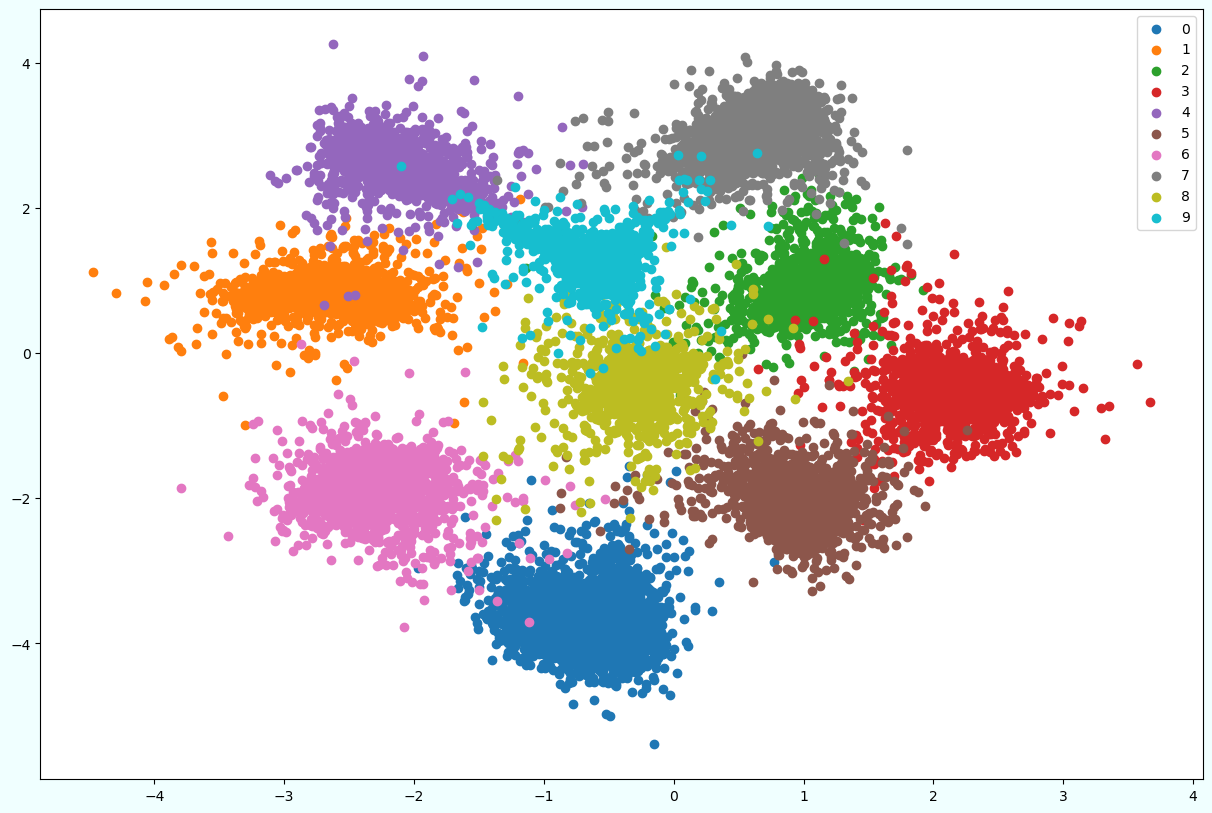

In [28]:
plt.figure(figsize=(15, 10), facecolor="azure")
for label in np.unique(labels):
    tmp = train_results[labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)

plt.legend()
plt.show()


  0%|          | 0/875 [00:00<?, ?it/s]

(28000, 2)

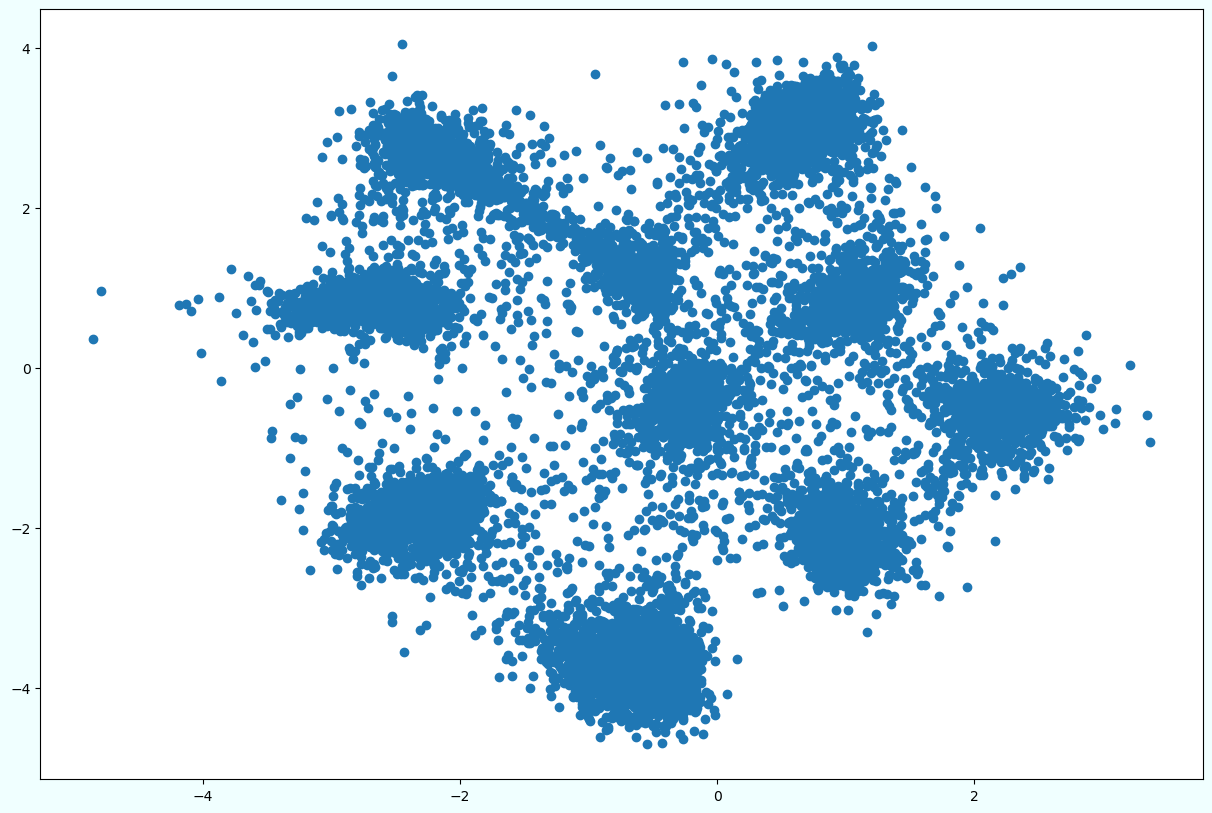

In [31]:
test_results = []
test_labels = []

model.eval()
with torch.no_grad():
    for img in tqdm(test_loader):
        test_results.append(model(img.to(device)).cpu().numpy())

test_results = np.concatenate(test_results)

plt.figure(figsize=(15, 10), facecolor="azure")
plt.scatter(test_results[:, 0], test_results[:, 1], label=label)

test_results.shape

## Accuracy (code adpted from Balys1)

In [49]:
model.eval()
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for img, a, b, label in tqdm(train_loader):
        pred = model(img.to(device))
        label_pred = torch.argmax(pred, dim = 1).cpu()
        correct_predictions += torch.sum((label == label_pred))
        total_predictions += len(label)
print(f'Accuracy: {correct_predictions / total_predictions}')

  0%|          | 0/1313 [00:00<?, ?it/s]

Accuracy: 0.20988094806671143


## Experimenting

In [50]:
train_ds = MNIST(train_df,
                 train=True,
                 transform=transforms.Compose([
                     transforms.ToTensor()
                 ]))
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)

In [51]:
test_ds = MNIST(test_df, train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4)

In [52]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight)

In [53]:
model = Network(embedding_dims)
model.apply(init_weights)
model = model.to(device)

epoch_count = 10
lr = 1e-3

optimizer = optim.Adam(model.parameters(), lr=lr)
loss_func = torch.nn.TripletMarginLoss()

model.train()
for epoch in tqdm(range(epoch_count), desc="Epochs"):
    running_loss = []
    for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)

        anchor_out = model(anchor_img)
        positive_out = model(positive_img)
        negative_out = model(negative_img)

        loss = loss_func(anchor_out, positive_out, negative_out)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss.append(loss.cpu().detach().numpy())
    print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, epochs, np.mean(running_loss)))

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 1/50 - Loss: 0.1929


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 2/50 - Loss: 0.0784


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 3/50 - Loss: 0.0591


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 4/50 - Loss: 0.0509


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 5/50 - Loss: 0.0471


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 6/50 - Loss: 0.0387


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 7/50 - Loss: 0.0360


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 8/50 - Loss: 0.0352


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 9/50 - Loss: 0.0333


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 10/50 - Loss: 0.0319


In [55]:
train_results = []
labels = []

model.eval()
with torch.no_grad():
    for img, _, _, label in tqdm(train_loader):
        train_results.append(model(img.to(device)).cpu().numpy())
        labels.append(label)

train_results = np.concatenate(train_results)
labels = np.concatenate(labels)
train_results.shape

  0%|          | 0/1313 [00:00<?, ?it/s]

(42000, 2)

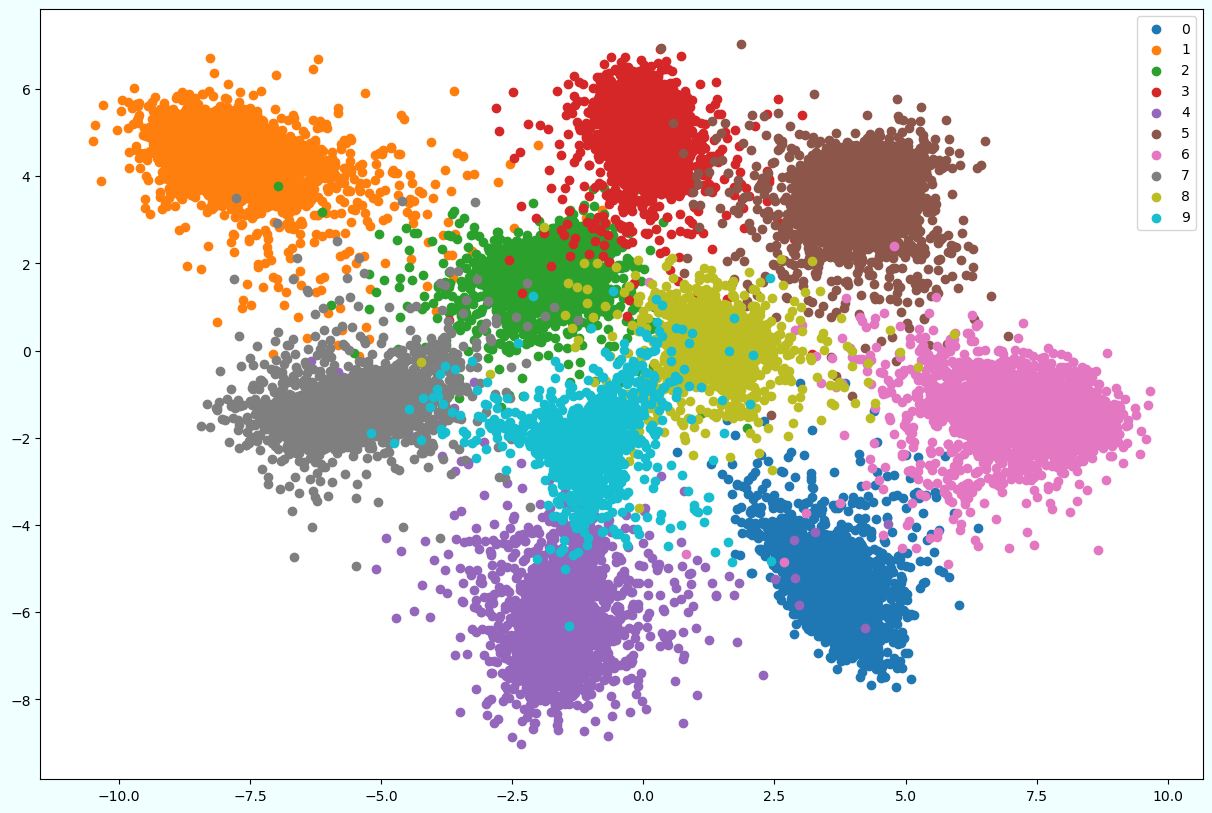

In [56]:
plt.figure(figsize=(15, 10), facecolor="azure")
for label in np.unique(labels):
    tmp = train_results[labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)

plt.legend()
plt.show()

In [57]:
model.eval()
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for img, a, b, label in tqdm(train_loader):
        pred = model(img.to(device))
        label_pred = torch.argmax(pred, dim = 1).cpu()
        correct_predictions += torch.sum((label == label_pred))
        total_predictions += len(label)
print(f'Accuracy: {correct_predictions / total_predictions}')

  0%|          | 0/1313 [00:00<?, ?it/s]

Accuracy: 0.2099047601222992


In [ ]:
f"Hello, {name}. You are {age}."